## Group 10 - First Year Project 
### Data Science at ITU 
## Project 2  


# Imports

In [84]:
import numpy as np
import pandas as pd
import folium
import json
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import rcParams
import seaborn as sns

# Loading Data

In [85]:
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

SUBPATH = {}
SUBPATH["corona"] = "corona/"
SUBPATH["meta"] = "metadata/"
SUBPATH["shape"] = "shapefiles/"
SUBPATH["weather"] = "weather/"

FILENAME = {}

FILENAME["corona"] = "de_corona.csv"
FILENAME["meta"] = "de_metadata.json"
FILENAME["shape"] = "de.geojson"
FILENAME["weather"] = "weather.csv"

corona = PATH["data_raw"]+SUBPATH["corona"]+FILENAME["corona"]
meta = PATH["data_raw"]+SUBPATH["meta"]+FILENAME["meta"]
shape = PATH["data_raw"]+SUBPATH["shape"]+FILENAME["shape"]
weather = PATH["data_raw"]+SUBPATH["weather"]+FILENAME["weather"]

In [143]:
raw_data = {}

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

raw_data['corona'] = pd.read_csv(corona, sep='\s+', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = pd.read_csv(weather, sep='\s+', parse_dates=['date'])

with open(meta, 'r', encoding='utf-8') as f:
    country_metadata = json.load(f)

# Dimension

In [87]:
raw_data["corona"]

,date,region_code,confirmed_addition,deceased_addition
0,2020-01-02,Nordrhein-Westfalen,1,0
1,2020-01-07,Nordrhein-Westfalen,1,0
2,2020-01-09,Nordrhein-Westfalen,1,1
3,2020-01-12,Nordrhein-Westfalen,1,0
4,2020-01-14,Nordrhein-Westfalen,1,0
...,...,...,...,...
5597,2021-02-21,Rheinland-Pfalz,120,0
5598,2021-02-21,Sachsen,68,0
5599,2021-02-21,Sachsen-Anhalt,84,0
5600,2021-02-21,Schleswig-Holstein,113,0


In [88]:
raw_data["weather"]

,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-13,DE-BB,76.337444,1.824290e+06,2.403341e+06,276.551573,0.003355,2.777806,4.542822
1,2020-02-13,DE-BE,76.065297,1.786373e+06,2.408182e+06,276.844633,0.003523,4.671329,4.761509
2,2020-02-13,DE-BW,80.113988,1.505760e+06,2.290158e+06,276.227143,0.008013,4.268546,4.467024
3,2020-02-13,DE-BY,81.554346,2.363013e+06,2.275361e+06,275.583053,0.005227,4.417797,3.677414
4,2020-02-13,DE-HB,87.167414,8.389756e+03,2.406940e+06,276.237452,0.007715,1.794872,4.699573
...,...,...,...,...,...,...,...,...,...
14899,2020-11-14,SE-U,93.442738,4.831112e+04,2.410483e+06,279.246340,0.000360,0.000000,2.022863
14900,2020-11-14,SE-W,94.633991,1.790715e+04,2.316636e+06,277.356327,0.002467,0.000000,2.660086
14901,2020-11-14,SE-X,91.194131,3.040221e+04,2.371160e+06,278.566463,0.000939,0.000000,2.286798
14902,2020-11-14,SE-Y,89.264026,1.481068e+04,2.359827e+06,278.493415,0.001144,0.000000,3.152586


# Sanity Check

make a sanity check: are there missing values anywhere in the weather data?

In [89]:
print(raw_data["weather"].isna().any().any())

False


In [90]:
raw_data["weather"]["TemperatureAboveGround"] = raw_data["weather"]["TemperatureAboveGround"] - 273.15

# Filter Data

### Region names with iso3166-2 codes and population

In [91]:
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}

raw_data["corona"]["region"] = raw_data["corona"]["region_code"].map(region_map)

corona_df_by_region = raw_data["corona"].groupby(by = "region")["confirmed_addition", "deceased_addition", ].sum().reset_index()


population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population"] for i in range(len(country_metadata["country_metadata"]))}

corona_df_by_region["population"] = corona_df_by_region["region"].map(population_map)

corona_df_by_region

<ipython-input-91-bdaa05a73c1b>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  corona_df_by_region = raw_data["corona"].groupby(by = "region")["confirmed_addition", "deceased_addition", ].sum().reset_index()


,region,confirmed_addition,deceased_addition,population
0,DE-BB,74955,2914,2511917
1,DE-BE,126896,2728,3644826
2,DE-BW,311152,7940,11069533
3,DE-BY,428996,12123,13076721
4,DE-HB,17485,327,682986
5,DE-HE,184434,5672,6265809
6,DE-HH,50291,1223,1841179
7,DE-MV,23436,692,1609675
8,DE-NI,159191,4104,7982448
9,DE-NW,521548,12632,17932651


## make the weather data human readable

Temperature, Humidity and Wind are in daily averages, the rest is in daily sums ?? - divide them by 24 - not for some variables like, e.g., precipitation

Humidity % , 

SolarRadiation
The units of measure are Watts per square meter. Above the earth's atmosphere, solar radiation has an intensity of approximately 1380 watts per square meter (W/m2). This value is known as the Solar Constant. At our latitude, the value at the surface is approximately 1000 W/m2 on a clear day at solar noon in the summer months.

Surfacepressure 920-1068 hPa

TemperatureAboveGround Kelvin
 
Totalprecipitation (mm) 

UVIndex 0-11

Wind-speed (maximum wind gust of 113.3 m/s (408 km/h)


# Numerical summary

## Germany corona dataset

There are 16 regions

In [95]:
pd.Series(raw_data['corona']['region_code']).unique()

array(['Nordrhein-Westfalen', 'Berlin', 'Saarland', 'Bayern',
       'Niedersachsen', 'Mecklenburg-Vorpommern', 'Brandenburg',
       'Baden-Württemberg', 'Hessen', 'Rheinland-Pfalz',
       'Schleswig-Holstein', 'Hamburg', 'Bremen', 'Sachsen', 'Thüringen',
       'Sachsen-Anhalt'], dtype=object)

### Daily registered cases in Germany

In [96]:
raw_data["corona"].describe()

,confirmed_addition,deceased_addition
count,5602.000000,5602.000000
mean,426.786862,12.121028
std,831.095886,25.823844
min,1.000000,0.000000
25%,18.000000,0.000000
50%,95.000000,1.000000
75%,396.000000,10.000000
max,6809.000000,213.000000


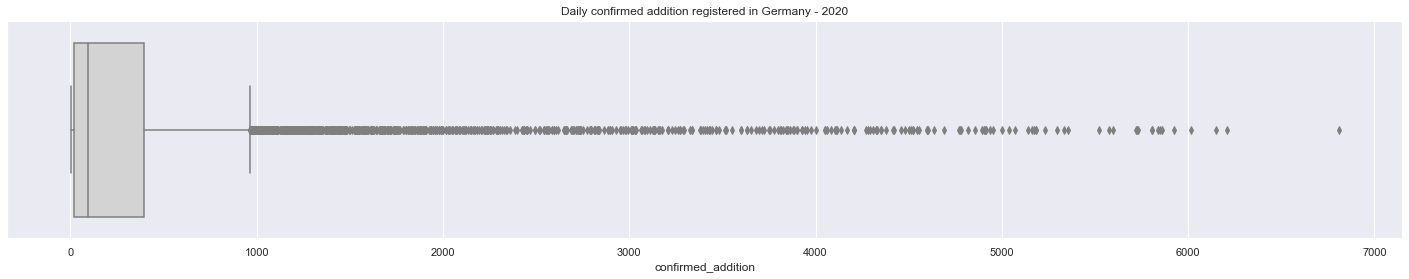

In [120]:
deCorona_confirmed = raw_data['corona']['confirmed_addition']
sns.boxplot(deCorona_confirmed, color='lightgray').set_title('Daily confirmed addition registered in Germany - 2020')
# figure size in inches
rcParams['figure.figsize'] = 25,4;

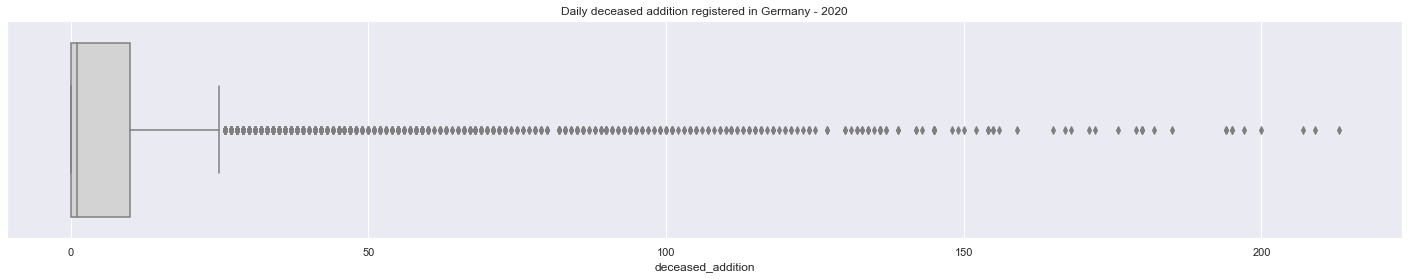

In [98]:
deCorona_deceased = raw_data['corona']['deceased_addition']
sns.boxplot(deCorona_deceased, color='lightgray').set_title('Daily deceased addition registered in Germany - 2020')
# figure size in inches
rcParams['figure.figsize'] = 25,5;

### 2020 - all registered cases in Germany

In [99]:
corona_df_by_region.describe()

,confirmed_addition,deceased_addition,population
count,16.000000,16.000000,1.600000e+01
mean,149428.750000,4243.875000,5.188701e+06
std,150077.793995,3898.816417,4.936479e+06
min,17485.000000,327.000000,6.829860e+05
25%,47996.500000,1220.000000,2.067654e+06
50%,87536.500000,2828.000000,3.270769e+06
75%,186028.750000,6119.000000,6.694969e+06
max,521548.000000,12632.000000,1.793265e+07


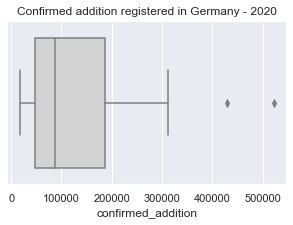

In [122]:
CoronaSUM_confirmed = corona_df_by_region['confirmed_addition']
sns.boxplot(CoronaSUM_confirmed, color='lightgray').set_title('Confirmed addition registered in Germany - 2020')
# figure size in inches
rcParams['figure.figsize'] = 5, 3;

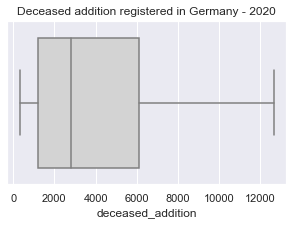

In [101]:
CoronaSUM_deceased = corona_df_by_region['deceased_addition']
sns.boxplot(CoronaSUM_deceased, color='lightgray').set_title('Deceased addition registered in Germany - 2020')
# figure size in inches
rcParams['figure.figsize'] = 5,3;

### Number of cases per capita

In [102]:
corona_df_by_region['confirmed/pop'] = corona_df_by_region['confirmed_addition']/corona_df_by_region['population']

In [103]:
corona_df_by_region['deceased/pop'] = corona_df_by_region['deceased_addition']/corona_df_by_region['population']
print(corona_df_by_region)

   region  confirmed_addition  deceased_addition  population  confirmed/pop  \
0   DE-BB               74955               2914     2511917       0.029840   
1   DE-BE              126896               2728     3644826       0.034815   
2   DE-BW              311152               7940    11069533       0.028109   
3   DE-BY              428996              12123    13076721       0.032806   
4   DE-HB               17485                327      682986       0.025601   
5   DE-HE              184434               5672     6265809       0.029435   
6   DE-HH               50291               1223     1841179       0.027315   
7   DE-MV               23436                692     1609675       0.014559   
8   DE-NI              159191               4104     7982448       0.019943   
9   DE-NW              521548              12632    17932651       0.029084   
10  DE-RP              100118               2993     4084844       0.024510   
11  DE-SH               41113               1211    

In [104]:
corona_df_by_region.groupby("region")["deceased/pop", "confirmed/pop"].describe()

<ipython-input-104-6de09c972275>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  corona_df_by_region.groupby("region")["deceased/pop", "confirmed/pop"].describe()


deceased/pop                                                        \
              count      mean std       min       25%       50%       75%   
region                                                                      
DE-BB           1.0  0.001160 NaN  0.001160  0.001160  0.001160  0.001160   
DE-BE           1.0  0.000748 NaN  0.000748  0.000748  0.000748  0.000748   
DE-BW           1.0  0.000717 NaN  0.000717  0.000717  0.000717  0.000717   
DE-BY           1.0  0.000927 NaN  0.000927  0.000927  0.000927  0.000927   
DE-HB           1.0  0.000479 NaN  0.000479  0.000479  0.000479  0.000479   
DE-HE           1.0  0.000905 NaN  0.000905  0.000905  0.000905  0.000905   
DE-HH           1.0  0.000664 NaN  0.000664  0.000664  0.000664  0.000664   
DE-MV           1.0  0.000430 NaN  0.000430  0.000430  0.000430  0.000430   
DE-NI           1.0  0.000514 NaN  0.000514  0.000514  0.000514  0.000514   
DE-NW           1.0  0.000704 NaN  0.000704  0.000704  0.000704  0.000704   
DE-RP           1.0  0.000733 NaN  0.000733  0.000733  0.000733  0.000733   
DE-SH           1.0  0.000418 NaN  0.000418  0.000418  0.000418  0.000418   
DE-SL           1.0  0.000856 NaN  0.000856  0.000856  0.000856  0.000856   
DE-SN           1.0  0.001829 NaN  0.001829  0.001829  0.001829  0.001829   
DE-ST           1.0  0.001038 NaN  0.001038  0.001038  0.001038  0.001038   
DE-TH           1.0  0.001279 NaN  0.001279  0.001279  0.001279  0.001279   

                 confirmed/pop                                              \
             max         count      mean std       min       25%       50%   
region                                                                       
DE-BB   0.001160           1.0  0.029840 NaN  0.029840  0.029840  0.029840   
DE-BE   0.000748           1.0  0.034815 NaN  0.034815  0.034815  0.034815   
DE-BW   0.000717           1.0  0.028109 NaN  0.028109  0.028109  0.028109   
DE-BY   0.000927           1.0  0.032806 NaN  0.032806  0.032806  0.032806   
DE-HB   0.000479           1.0  0.025601 NaN  0.025601  0.025601  0.025601   
DE-HE   0.000905           1.0  0.029435 NaN  0.029435  0.029435  0.029435   
DE-HH   0.000664           1.0  0.027315 NaN  0.027315  0.027315  0.027315   
DE-MV   0.000430           1.0  0.014559 NaN  0.014559  0.014559  0.014559   
DE-NI   0.000514           1.0  0.019943 NaN  0.019943  0.019943  0.019943   
DE-NW   0.000704           1.0  0.029084 NaN  0.029084  0.029084  0.029084   
DE-RP   0.000733           1.0  0.024510 NaN  0.024510  0.024510  0.024510   
DE-SH   0.000418           1.0  0.014193 NaN  0.014193  0.014193  0.014193   
DE-SL   0.000856           1.0  0.028325 NaN  0.028325  0.028325  0.028325   
DE-SN   0.001829           1.0  0.046792 NaN  0.046792  0.046792  0.046792   
DE-ST   0.001038           1.0  0.026570 NaN  0.026570  0.026570  0.026570   
DE-TH   0.001279           1.0  0.034390 NaN  0.034390  0.034390  0.034390   

                            
             75%       max  
region                      
DE-BB   0.029840  0.029840  
DE-BE   0.034815  0.034815  
DE-BW   0.028109  0.028109  
DE-BY   0.032806  0.032806  
DE-HB   0.025601  0.025601  
DE-HE   0.029435  0.029435  
DE-HH   0.027315  0.027315  
DE-MV   0.014559  0.014559  
DE-NI   0.019943  0.019943  
DE-NW   0.029084  0.029084  
DE-RP   0.024510  0.024510  
DE-SH   0.014193  0.014193  
DE-SL   0.028325  0.028325  
DE-SN   0.046792  0.046792  
DE-ST   0.026570  0.026570  
DE-TH   0.034390  0.034390

### The number of days when more than 500 /1000 confirmed addition were registered by region

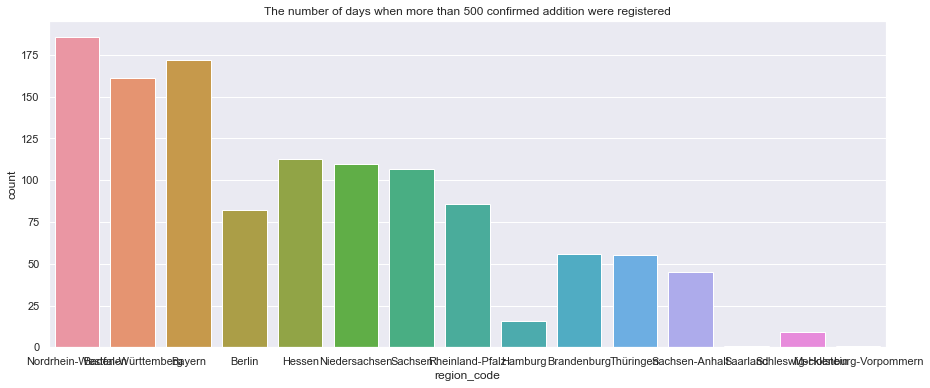

In [124]:
sns.set(style="darkgrid")
moreThan500 = (raw_data['corona']['confirmed_addition']>500)
ax = sns.countplot(x="region_code", data=raw_data['corona'][moreThan500]).set_title('The number of days when more than 500 confirmed addition were registered')
rcParams['figure.figsize'] = 15,6;

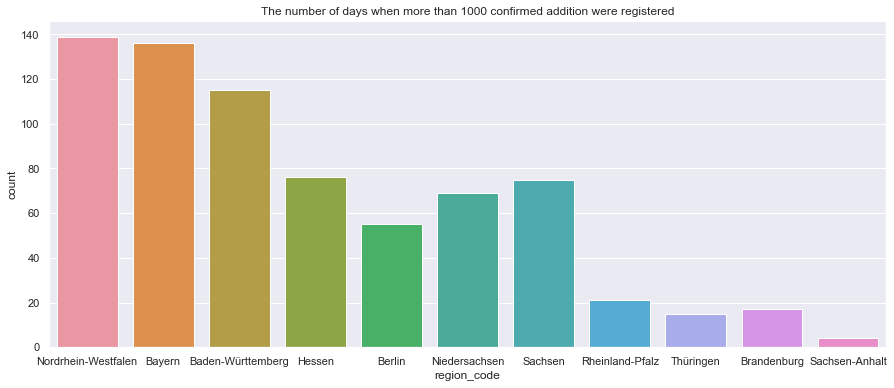

In [106]:

sns.set(style="darkgrid")
moreThan1000 = (raw_data['corona']['confirmed_addition']>1000)
ax = sns.countplot(x="region_code", data=raw_data['corona'][moreThan1000]).set_title('The number of days when more than 1000 confirmed addition were registered')

### The number of cases by region per capita

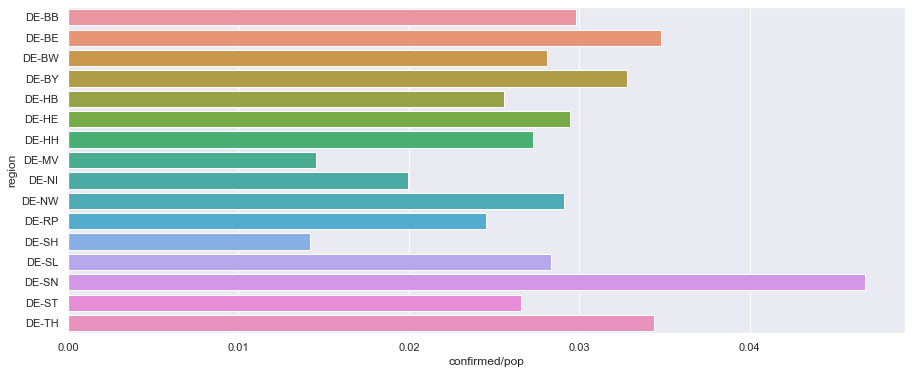

In [107]:
ax = sns.barplot(x="confirmed/pop", y="region", data=corona_df_by_region)

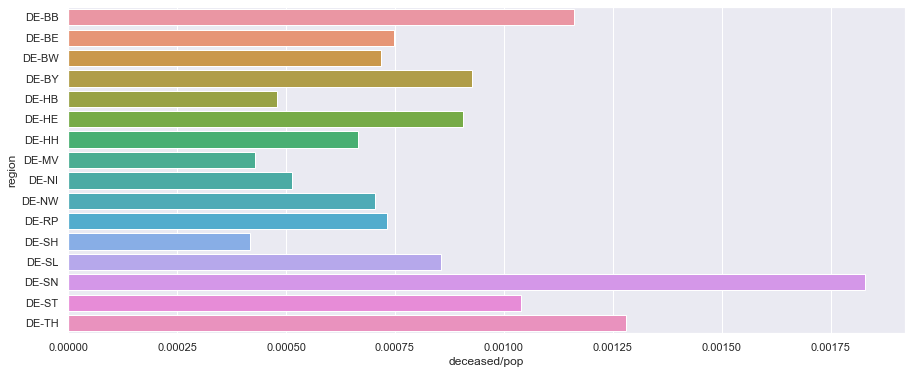

In [108]:
ax = sns.barplot(x="deceased/pop", y="region", data=corona_df_by_region)

### The number of cases monthly in Germany

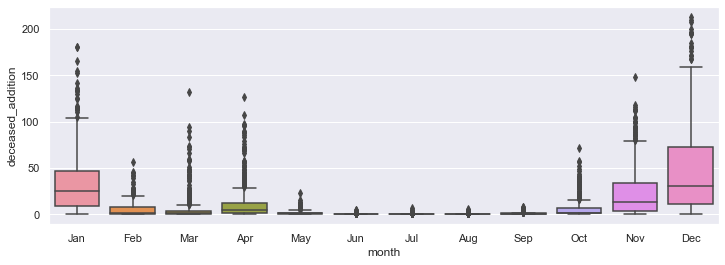

In [109]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x='month',y='deceased_addition',data=raw_data['corona'],ax=ax).set_title("")
plt.show()

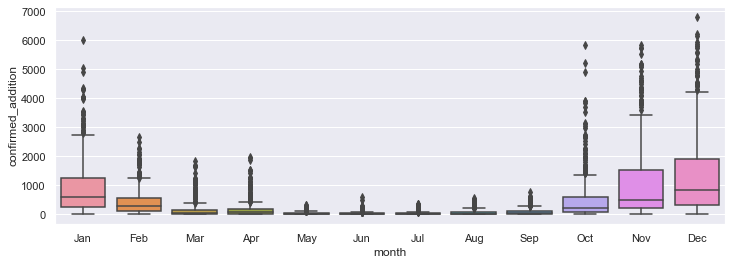

In [110]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x='month',y='confirmed_addition',data=raw_data['corona'],ax=ax).set_title("")
plt.show()

In [174]:
datetime_series = pd.to_datetime(raw_data['weather']['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df2=raw_data['weather'].set_index(datetime_index)
raw_data['weather'].drop('date', axis=1,inplace=True);

KeyError: 'date'

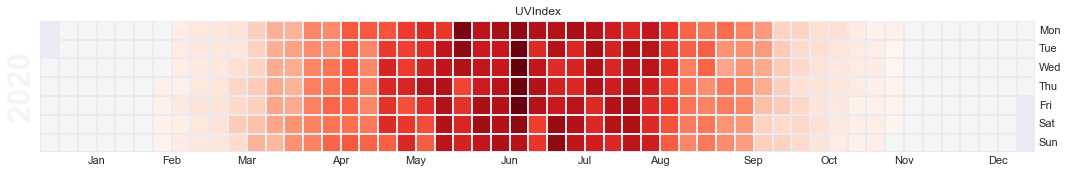

In [175]:
import calmap     

calmap.calendarplot(df2['UVIndex'])
plt.title("UVIndex");

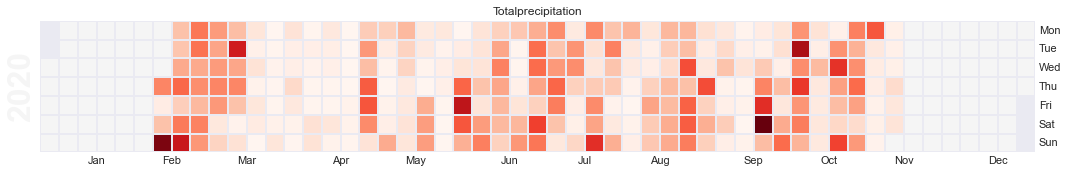

In [170]:
calmap.calendarplot(df2['Totalprecipitation'])
plt.title("Totalprecipitation");

Text(0.5, 1.0, 'WindSpeed')

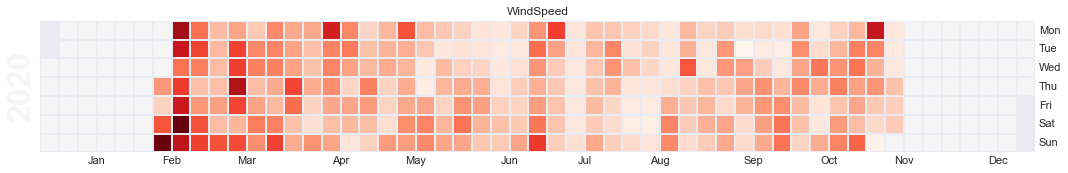

In [176]:
calmap.calendarplot(df2['WindSpeed'])
plt.title("WindSpeed")

Text(0.5, 1.0, 'RelativeHumiditySurface')

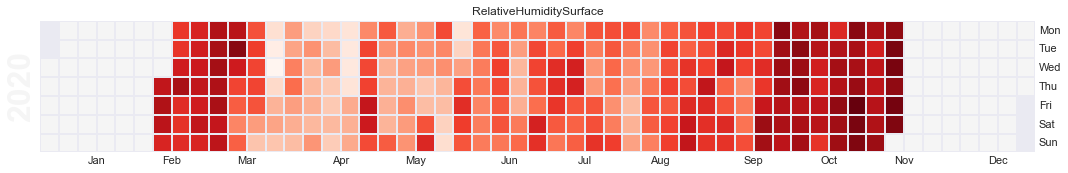

In [177]:
import calmap     

calmap.calendarplot(df2['RelativeHumiditySurface'])
plt.title("RelativeHumiditySurface")